In [2]:
import os
from river import evaluate, metrics, neighbors, stream


In [26]:
metric = getattr(metrics, 'Accuracy')
metric()

Accuracy: 0.00%

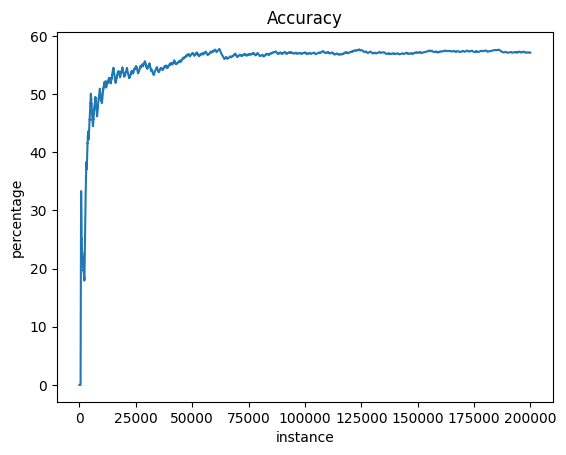

In [3]:
bases = ['chess', 'rbf', 'sea', 'squares']


# o iter_csv lê os dados do arquivo como string, por essa 
# razão é necessário converter os dados para tipos numéricos
converter = {
    'chess': {'x':float, 'y': float, 'labels':int}, 
    'rbf': {
        'x0':float, 'x1':float, 'x2':float, 'x3':float, 
        'x4':float, 'x5':float, 'x6':float, 'x7':float, 
        'x8':float, 'x9':float, 'labels':int}, 
    'sea': {'x':float, 'y': float, 'labels':int},
    'squares': {'x':float, 'y': float, 'labels':int}}
drop = None
target = 'labels'
dataset = stream.iter_csv(
    f'artificial/{bases[0]}/{bases[0]}.csv', 
    converters=converter[bases[0]], 
    target=target,
    drop=drop)

# o modelo SAMKNNClassifier foi adicionado manualmente ao river
# a partir do código disponível na versão 0.10.1, por razões
# internas do river, o modelo não foi adicionado às demais versões
model = neighbors.SAMKNNClassifier(
    window_size=1000, 
    n_neighbors=3)


all_metrics = [
    'Accuracy', 
    'Precision', 
    'Recall', 
    'ROCAUC',
    'F1',
    'GeometricMean']
delay = 1000

os.makedirs(f'artificial/{bases[0]}/', exist_ok=True)
with open(f'artificial/{bases[0]}/{all_metrics[0]}.csv', 'w') as f:
    eval = evaluate.progressive_val_score(
        dataset, 
        model, 
        metric=getattr(metrics, 'Accuracy')(), 
        delay=delay, 
        print_every=1, 
        file=f)

try:
    reader = open(f'artificial/{bases[0]}/{all_metrics[0]}.csv', 'r')
    dicti = {}
    Lines = reader.readlines()
    for row in Lines:
        colunas = row.split()
        n_answer = int(colunas[0].strip('[]').replace(',',''))
        metric_title = colunas[1].strip(':')
        percentage = float(colunas[2].strip('%'))
        if dicti.get(metric_title) is None: 
            dicti[metric_title] = {}
        dicti[metric_title].update({n_answer :percentage})
except OSError:
    print ('Could not open/read file:', file)
    exit()

import matplotlib.pyplot as plt

for metric_key in dicti.keys():
    plt.figure()
    plt.title(metric_key)
    plt.xlabel('instance')
    plt.ylabel('percentage')
    plt.plot(dicti[metric_key].keys(), dicti[metric_key].values())